In [1]:
import sys
# sys.path.append(r"Y:\Users\Yingyue\Gates_Lab_Suite-master")
sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master")
from Core_Definition import *
from Auto_Algorithm import *
from Visualization import *
import os
from SPAM import *
import numpy as np
import xlsxwriter as xlsx
from scipy import optimize
import random
import math
from math import floor
import pickle
import uuid

In [2]:
import json, pickle
import qiskit
#transpiler reducinig qiskit circuit to QASM strings
from qiskit import transpile
# Use AerSimulator
from qiskit_aer import AerSimulator
from qiskit import IBMQ, QuantumCircuit, execute
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import Pauli, Clifford, Statevector,Operator
from qiskit.visualization import array_to_latex
from scipy.stats import sem, unitary_group
from scipy.linalg import sqrtm,expm
import qiskit.quantum_info as qi
from qiskit.quantum_info import Pauli
import pylatexenc

In [3]:
from scipy.optimize import curve_fit
from copy import copy, deepcopy
def rcs_fit_fun_depth1(x, alpha):
        #return a * np.exp(-alpha * x)
        return alpha ** x

def fit_EAB_depth1(X, xeb_list):
    Y = [np.mean(xeb_list[L]) for L in X]
    Yerr = [sem(xeb_list[L]) for L in X]
    #print(linregress(X,np.log(Y)))
    
    
    try:
        params, pcov = curve_fit(rcs_fit_fun_depth1, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1])
        alpha = params[0]
        params_err = np.sqrt(np.diag(pcov))
        alpha_err = params_err[0]

    except RuntimeError:
        alpha = 1.0
        alpha_err = 0.0


    return alpha, alpha_err

    print(alpha, alpha_err)

def int_to_pauli(i,n):
    p = np.base_repr(i,base=4)
    p = '0'*(n-len(p)) + p
    p = p.replace('0','I').replace('1', 'X').replace('2', 'Y').replace('3', 'Z')
    return p

def commute(p,q):
    c = 1
    n = len(p)
    for i in range(n):
        if p[i] != 'I' and q[i] != 'I':
            if p[i] != q[i]:
                c *= -1
    return c

def fidelity_to_error(pauli_fidelity,n):
    N = 4**n
    pauli_error = {}
    for i in range(N):
        p = int_to_pauli(i,n)
        pauli_error[p] = 0
        for j in range(N):
            q = int_to_pauli(j,n)
            pauli_error[p] += pauli_fidelity[q] * commute(p,q) / N
    return pauli_error
    

In [4]:
import random   

#only eliminate one element in bootstrapping
def bootstrap_fit_EAB_plot(X, xeb_list):
    full_list=deepcopy(xeb_list)
    alpha_rtn_frm_fit=[0]*10
    alpha_err_rtn_frm_fit=[0]*10
    a_rtn_frm_fit=[0]*10
    Y_rtn_frm_fit=[0]*10
    Yerr_rtn_frm_fit=[0]*10
    for i in range (10):
        xeb_list_temp=deepcopy(full_list)
        for j in X:
            r=random.randint(0, 19)
#             print ("before random removal", len(xeb_list_temp[j]))
            xeb_list_temp[j].remove(xeb_list_temp[j][r])
#             print ("after random removal", len(xeb_list_temp[j]))
            assert len(xeb_list_temp[j])==19
#         print (i)
        alpha_rtn_frm_fit[i], a_rtn_frm_fit[i],alpha_err_rtn_frm_fit[i],Y_rtn_frm_fit[i],Yerr_rtn_frm_fit[i]= fit_EAB_plot(X, xeb_list_temp)
#         print (alpha_rtn_frm_fit[i])
    alpha_bootstrap=np.mean(alpha_rtn_frm_fit)
    alpha_err_bootstrap=np.std(alpha_rtn_frm_fit)
    return alpha_bootstrap,alpha_err_bootstrap, alpha_rtn_frm_fit,a_rtn_frm_fit, alpha_err_rtn_frm_fit,Y_rtn_frm_fit,Yerr_rtn_frm_fit
    
#specify number of elements to resample : rs
def bootstrap_fit_EAB_plot_rs(X, xeb_list,rs):
    full_list=deepcopy(xeb_list)        
    alpha_rtn_frm_fit=[0]*10
    alpha_err_rtn_frm_fit=[0]*10
    a_rtn_frm_fit=[0]*10
    Y_rtn_frm_fit=[0]*10
    Yerr_rtn_frm_fit=[0]*10
    for i in range (10):
        xeb_list_temp=deepcopy(full_list)
        for j in X:
#             print ("before random removal", len(xeb_list_temp[j]))
            for m in range (20-rs):
                r=random.randint(0,20-m-1)
#                 r=random.sample(range(20), 20-rs)
                xeb_list_temp[j].remove(xeb_list_temp[j][r])
#             print ("after random removal", len(xeb_list_temp[j]))
            assert len(xeb_list_temp[j])==rs
        print ("i,j",i,j)
        alpha_rtn_frm_fit[i], a_rtn_frm_fit[i],alpha_err_rtn_frm_fit[i],Y_rtn_frm_fit[i],Yerr_rtn_frm_fit[i]= fit_EAB_plot(X, xeb_list_temp)
#         print (alpha_rtn_frm_fit[i])
    alpha_bootstrap=np.mean(alpha_rtn_frm_fit)
    alpha_err_bootstrap=np.std(alpha_rtn_frm_fit)
    return alpha_bootstrap,alpha_err_bootstrap, alpha_rtn_frm_fit,a_rtn_frm_fit, alpha_err_rtn_frm_fit,Y_rtn_frm_fit,Yerr_rtn_frm_fit



In [5]:
# filename = str(uuid.uuid4())
# filename+="XX23541_noSE_explicitCNOT_XX_R_0711_01+10_ExperimentalData"
with open("/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation/data/0711/eab_results_file/fd7015be-f0ce-4460-a192-7451a38ac107XX23541_noSE_explicitCNOT_XX_R_0711_01+10_ExperimentalData_SPAM", "rb") as fp:
    eab_load_cpy=pickle.load(fp)

In [6]:
sys.path.append(r"/Volumes/funkflower/Users/Yingyue/Gates_Lab_Suite-master/PauliNoiseEstimation")
import EAB_process_modified 
import itertools
import pdb

'''Specify a set of Pauli you want to estimate'''
# C=10
C=20
nqubit=2
depth=[2,4,8,16,32]
pauli_request_list = [''.join(s) for s in itertools.product(['I','X','Y','Z'], repeat = nqubit)] #full

#process_EAB(Lrange, cb_data, pauli_request_list)
eab_result=EAB_process_modified.process_EAB_01(depth, eab_load_cpy, pauli_request_list)
# eab_result_spam=EAB_process_modified.process_EAB(depth, eab_load_cpy_spam, pauli_request_list)

print (eab_result)


{'fidelity_list': {'II': {2: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 8: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 16: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 32: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, 'IX': {2: [0.8350824587706147, 0.898, 0.8159079539769885, 0.8848848848848849, 0.822911455727864, 0.889, 0.8608608608608609, 0.83, 0.8319159579789895, 0.842, 0.8291708291708292, 0.87, 0.8820589705147426, 0.831, 0.8991008991008991, 0.7841079460269865, 0.8841158841158842, 0.919080919080919, 0.9099099099099099, 0.9109554777388694], 4: [0.7747747747747747, 0.7122877122877123, 0.779, 0.6883116883116883, 0.8220889555222389, 0.7068534267133567, 0.866

Data analysis

In [7]:
raw_fidelity_list = eab_result["fidelity_list"]

#######depth=[2]#########
##########################
plot_dic={}
error_dic={}
err=[]
# sys.exit(0)
depth=[2]
fidelity_list = {}
stdev_list = {}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha, alpha_err = fit_EAB_depth1(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha
        stdev_list[pauli_label] = alpha_err

# print(fidelity_list)

# print(stdev_list)

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    error_dic[pauli_label[::-1]]=stdev_list[pauli_label]
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))

plot_2={}
plot_2=deepcopy(plot_dic)
err_2=deepcopy(error_dic)

#######depth=[2]#########
##########################
plot_dic={}
err=[]
# sys.exit(0)
depth=[2,4]
fidelity_list = {}
stdev_list = {}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha, alpha_err = EAB_process_modified.fit_EAB(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha
        stdev_list[pauli_label] = alpha_err

# print(fidelity_list)

# print(stdev_list)

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    error_dic[pauli_label[::-1]]=stdev_list[pauli_label]
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))

plot_24={}
plot_24=deepcopy(plot_dic)
err_24=deepcopy(error_dic)

#######depth=[2]#########
##########################
plot_dic={}
error_dic={}
error_dic={}
err=[]
# sys.exit(0)
depth=[2,4,8]
fidelity_list = {}
stdev_list = {}

for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha, alpha_err = EAB_process_modified.fit_EAB(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha
        stdev_list[pauli_label] = alpha_err

# print(fidelity_list)

# print(stdev_list)

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    error_dic[pauli_label[::-1]]=stdev_list[pauli_label]
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))

plot_248={}
plot_248=deepcopy(plot_dic)
err_248=deepcopy(error_dic)


Parameters: n = 2, C = 20,  L =  [2]
Measurement based simulation, shots = 2000
No readout error
Total error =  0.10926232647960288
Label / Pauli infidelity / Standard deviation
II 0.0 0.0
XI 0.0718280221893347 0.004594225850019
YI 0.08703759212512507 0.007212673654193234
ZI 0.05305860482243918 0.0046609651088203785
IX 0.10430840107652861 0.007311236257096888
XX 0.15562838077936547 0.00758656048461638
YX 0.1646790902772497 0.010565987666002455
ZX 0.1397918793663162 0.010202743299437862
IY 0.12583669695892008 0.012186215404757903
XY 0.1706856902707079 0.011024859263832789
YY 0.16449831010329063 0.008867520927263945
ZY 0.13457570170514688 0.008719446964312937
IZ 0.06688655518009345 0.0056132219771248965
XZ 0.12347100209392214 0.007412906380143479
YZ 0.1134332030289642 0.005406035353364949
ZZ 0.07247809369624136 0.0038645801072345405
Parameters: n = 2, C = 20,  L =  [2, 4]
Measurement based simulation, shots = 2000
No readout error
Total error =  0.02806720620779435
Label / Pauli infideli

In [8]:
def rcs_fit_fun(x, a, alpha):
        #return a * np.exp(-alpha * x)
        return a * (alpha ** x)

def fit_EAB_plot(X, xeb_list):
    Y = [np.mean(xeb_list[L]) for L in X]
    Yerr = [sem(xeb_list[L]) for L in X]
    #print(linregress(X,np.log(Y)))
    
    
    try:
        params, pcov = curve_fit(rcs_fit_fun, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1,1])
        alpha = params[1]
        a=params[0]
        params_err = np.sqrt(np.diag(pcov))
        alpha_err = params_err[1]

    except RuntimeError:
        alpha = 1.0
        alpha_err = 0.0

    # params, pcov = curve_fit(rcs_fit_fun, X, Y, sigma=Yerr, absolute_sigma=True, p0=[1,1])
    # #params, pcov = curve_fit(rcs_fit_fun, X, Y, absolute_sigma=True, p0=[1,1])


    # print(params)

    return alpha,a, alpha_err,Y, Yerr

    print(alpha, alpha_err)



plot average fidelity and fit

Parameters: n = 2, C = 20,  L =  [2, 4, 8, 16, 32]
Measurement based simulation, shots = 2000
No readout error
Total error =  0.02750735710008856
Label / Pauli infidelity / Standard deviation
II 0.0 0.0
XI 0.0145833 0.0008487
YI 0.0302446 0.0022032
ZI 0.0300633 0.0020385
IX 0.0177148 0.0012117
XX 0.029773 0.0012327
YX 0.0371663 0.0024545
ZX 0.0371786 0.0024746
IY 0.038402 0.0025924
XY 0.039383 0.0022475
YY 0.0366416 0.0014734
ZY 0.0292792 0.0014881
IZ 0.0308215 0.0020613
XZ 0.0315121 0.0022467
YZ 0.0233394 0.0010148
ZZ 0.0140152 0.0007282
{'IX': [0.8615032203929621, 0.7983988441810246, 0.8227480846305657, 0.7003421324233867, 0.5452383882197853], 'IY': [0.8335003581926894, 0.7332393017124517, 0.733440197315858, 0.5182718397142547, 0.30225526527770163], 'IZ': [0.8966980059008254, 0.8343356179737308, 0.7667821395561198, 0.5704209451495192, 0.3412470563220917], 'XI': [0.8022634403820847, 0.7982925046659438, 0.764376612023121, 0.6405722135061865, 0.4647684608746265], 'XX': [0.71296343134527

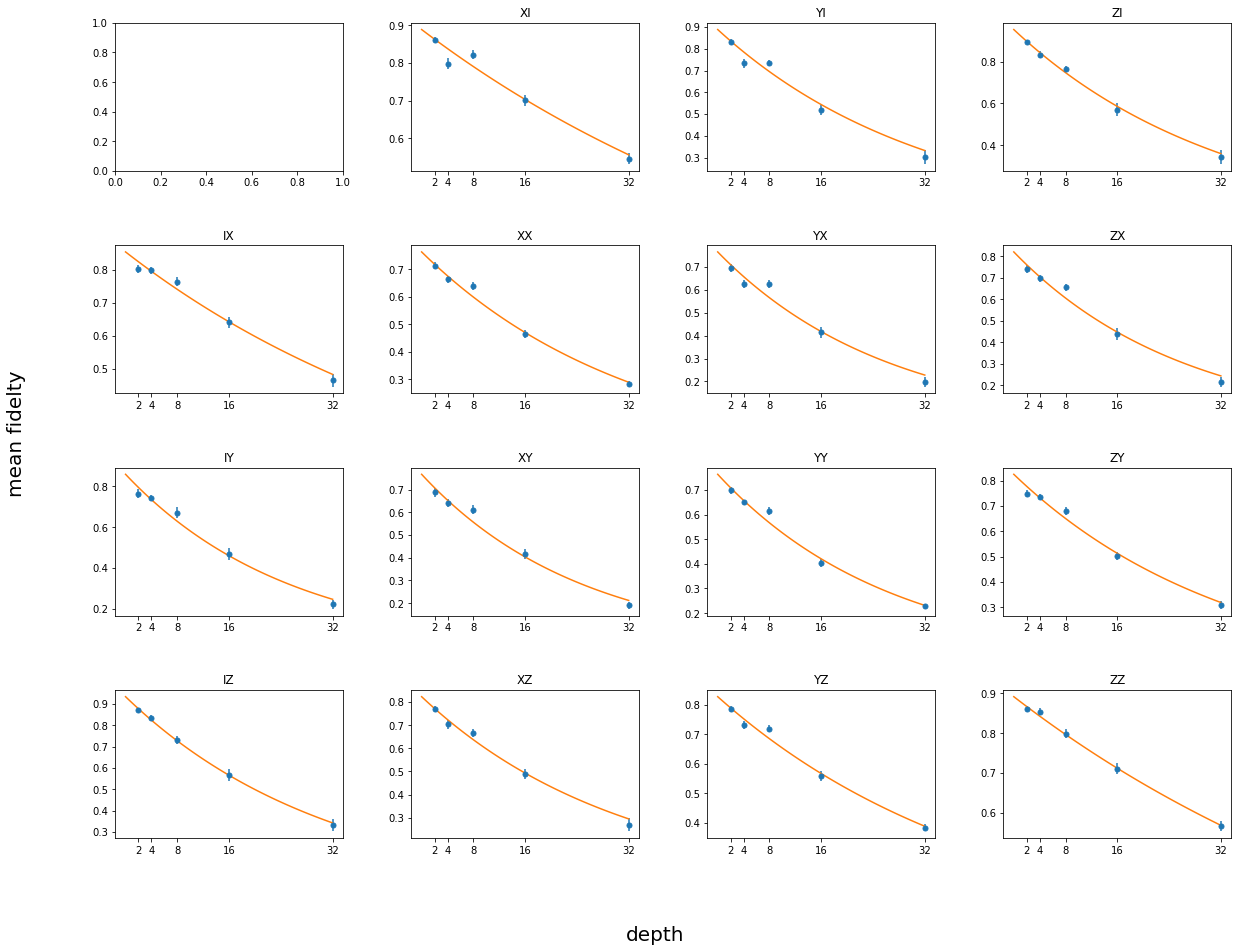

In [9]:
raw_fidelity_list = eab_result["fidelity_list"]
plot_dic={}
error_dic={}
# sys.exit(0)
depth=[2,4,8,16,32]
fidelity_list = {}
stdev_list = {}
a248_dic={}
Y248_dic={}
Yerr248_dic={}
for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha,a, alpha_err,Y, Yerr = fit_EAB_plot(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha #pauli fidelity from fit
        stdev_list[pauli_label] = alpha_err #error on pauli fidelity from fit
        a248_dic[pauli_label]=a 
        Y248_dic[pauli_label]=Y
        Yerr248_dic[pauli_label]=Yerr

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], round(1-fidelity_list[pauli_label],7), round(stdev_list[pauli_label],7))
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    error_dic[pauli_label[::-1]]=stdev_list[pauli_label]
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
# for pauli_label in pauli_request_list:
#     print(pauli_label[::-1], fidelity_list[pauli_label])

plot_248={}
plot_248=deepcopy(plot_dic)
err_248=deepcopy(error_dic)
print (Y248_dic)

x_c=np.linspace(0,32,num=80)
nqubit=2
fig, axs = plt.subplots(4, 4)
fig.set_figwidth(20)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
for i in range (4):
    for j in range(4):
        pauli_label=pauli_request_list[4*i+j]
        if (pauli_label == 'I'*nqubit):
#                 fidelity_list[pauli_label] = 1.0
#                 stdev_list[pauli_label] = 0.0
            pass
        else:
            axs[i, j].set_xticks([2,4,8,16,32])   
            axs[i, j].errorbar(depth,Y248_dic[pauli_label], yerr=Yerr248_dic[pauli_label], fmt='o',markersize=5)
            axs[i, j].plot(x_c,rcs_fit_fun(x_c,a248_dic[pauli_label], fidelity_list[pauli_label]))
            axs[i, j].set_title(pauli_label[::-1])
                
# for pauli_label in pauli_request_list:
# fig.savefig("fit.pdf", format="pdf", dpi=500)        

plot fidelity from each circuit and fit

In [10]:
error_list = fidelity_to_error(fidelity_list,nqubit)
print("Label / Pauli error rates")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], round(error_list[pauli_label],7))


Label / Pauli error rates
II 0.9724926
XI 0.0022337
YI 0.0007161
ZI 0.002823
IX 0.0029169
XX 0.0068391
YX 0.002593
ZX 0.0005283
IY 0.0001827
XY 0.0019989
YY 0.0002865
ZY 6.55e-05
IZ 0.0056849
XZ 0.0003595
YZ 5e-06
ZZ 0.0002744


Parameters: n = 2, C = 20,  L =  [2, 4, 8, 16, 32]
Measurement based simulation, shots = 2000
No readout error
Total error =  0.02750735710008856
Label / Pauli infidelity / Standard deviation
II 0.0 0.0
XI 0.014583326873994218 0.0008487376232296073
YI 0.030244577637438264 0.002203247619871534
ZI 0.03006330405372093 0.0020384891728613243
IX 0.017714762227980962 0.001211722360042054
XX 0.029772953571316263 0.0012326702832256248
YX 0.03716633643270861 0.002454471167012348
ZX 0.03717856583806456 0.0024746023575836283
IY 0.038402022009579206 0.0025923829282477897
XY 0.03938296455223178 0.0022474847982325774
YY 0.03664156611893432 0.0014734314655391004
ZY 0.02927916644713391 0.0014880535754209243
IZ 0.03082154222240263 0.002061315982532035
XZ 0.03151205789103417 0.0022466628145734802
YZ 0.023339387252917287 0.0010148266268729998
ZZ 0.014015180471961486 0.0007282213559223316
{'IX': [0.8615032203929621, 0.7983988441810246, 0.8227480846305657, 0.7003421324233867, 0.5452383882197853], 'IY': [0.8

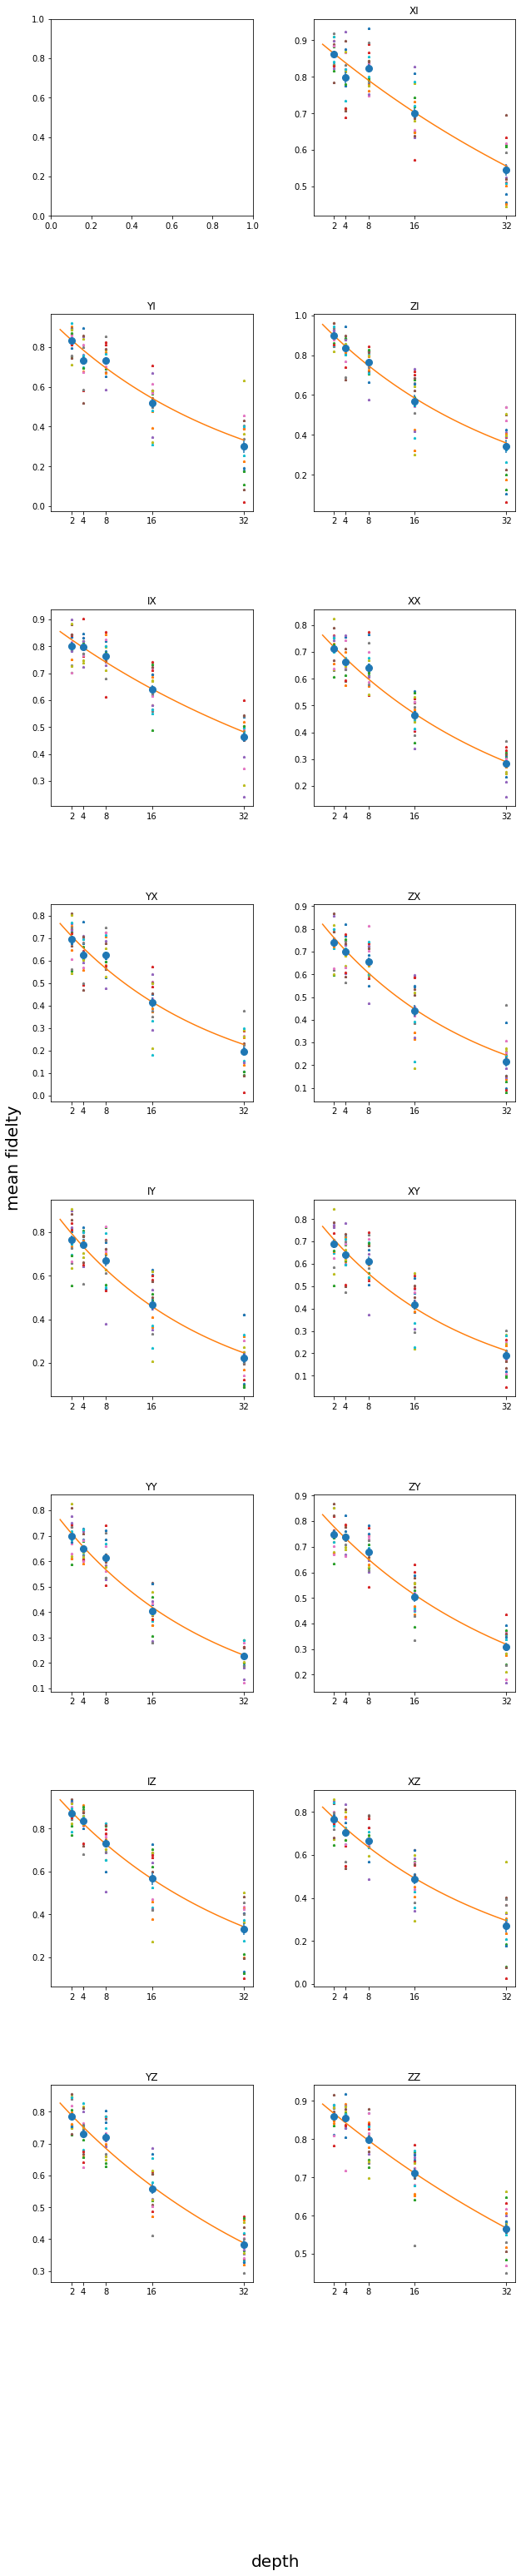

In [11]:
raw_fidelity_list = eab_result["fidelity_list"]
plot_dic={}
error_dic={}
# sys.exit(0)
depth=[2,4,8,16,32]
fidelity_list = {}
stdev_list = {}
a248_dic={}
Y248_dic={}
Yerr248_dic={}
for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha,a, alpha_err,Y, Yerr = fit_EAB_plot(depth, raw_fidelity_list[pauli_label])
        fidelity_list[pauli_label] = alpha #pauli fidelity from fit
        stdev_list[pauli_label] = alpha_err #error on pauli fidelity from fit
        a248_dic[pauli_label]=a 
        Y248_dic[pauli_label]=Y
        Yerr248_dic[pauli_label]=Yerr

print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))

print("Label / Pauli infidelity / Standard deviation")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], 1-fidelity_list[pauli_label], stdev_list[pauli_label])
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
    plot_dic[pauli_label[::-1]]=1-fidelity_list[pauli_label]
    error_dic[pauli_label[::-1]]=stdev_list[pauli_label]
# print('Effective noise rate = ' + str(1-np.average(list(fidelity_list.values()))))
# for pauli_label in pauli_request_list:
#     print(pauli_label[::-1], fidelity_list[pauli_label])

plot_248={}
plot_248=deepcopy(plot_dic)
err_248=deepcopy(error_dic)
print (Y248_dic)

x_c=np.linspace(0,32,num=80)
nqubit=2
fig, axs = plt.subplots(8, 2)
fig.set_figwidth(10)
fig.set_figheight(50)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
for i in range (8):
    for j in range(2):
        pauli_label=pauli_request_list[2*i+j]
        if (pauli_label == 'I'*nqubit):
#                 fidelity_list[pauli_label] = 1.0
#                 stdev_list[pauli_label] = 0.0
            pass
        else:
            axs[i, j].set_xticks([2,4,8,16,32])   
#             axs[i, j].errorbar(depth,Y248_dic[pauli_label], yerr=Yerr248_dic[pauli_label], fmt='o',markersize=5)
            print ([tuple(eab_result['fidelity_list'][pauli_label][2])])
#             axs[i, j].plot([2],[tuple(eab_result['fidelity_list'][pauli_label][2])],"*",markersize=3)
#             axs[i, j].plot([4],[tuple(eab_result['fidelity_list'][pauli_label][4])],"*",markersize=3)
#             axs[i, j].plot([8],[tuple(eab_result['fidelity_list'][pauli_label][8])],"*",markersize=3)
#             axs[i, j].plot([16],[tuple(eab_result['fidelity_list'][pauli_label][16])],"*",markersize=3)
#             axs[i, j].plot([32],[tuple(eab_result['fidelity_list'][pauli_label][32])],"*",markersize=3)
            axs[i, j].plot(depth,[tuple(eab_result['fidelity_list'][pauli_label][L]) for L in depth],"*",markersize=3)
            axs[i, j].errorbar(depth,Y248_dic[pauli_label], yerr=Yerr248_dic[pauli_label], fmt='o',markersize=8)
            axs[i, j].plot(x_c,rcs_fit_fun(x_c,a248_dic[pauli_label], fidelity_list[pauli_label]))
            axs[i, j].set_title(pauli_label[::-1])
                
# for pauli_label in pauli_request_list:
# fig.savefig("fit.pdf", format="pdf", dpi=500)        

data analysis with bootstrapping

Parameters: n = 2, C = 20,  L =  [2, 4, 8, 16, 32]
Measurement based simulation, shots = 2000
No readout error
Total error =  0.027480293204298123
XI 0.0145971 0.0004469
YI 0.0305523 0.001413
ZI 0.0296649 0.0018397
IX 0.0181067 0.000479
XX 0.0302236 0.0005271
YX 0.0374916 0.0011061
ZX 0.0367309 0.0018099
IY 0.0384451 0.0013313
XY 0.0388584 0.0018192
YY 0.0363932 0.0004045
ZY 0.0289708 0.0011129
IZ 0.0307234 0.0013661
XZ 0.0316373 0.0015034
YZ 0.0232956 0.0007979
ZZ 0.0139937 0.0005582
[0.986724730860929, 0.9865587779418395, 0.9865959400059096, 0.9855548481359873, 0.9859066423854804, 0.9861832104772971, 0.9864660363702961, 0.9853252432895067, 0.9857104130769851, 0.9850374872318223]


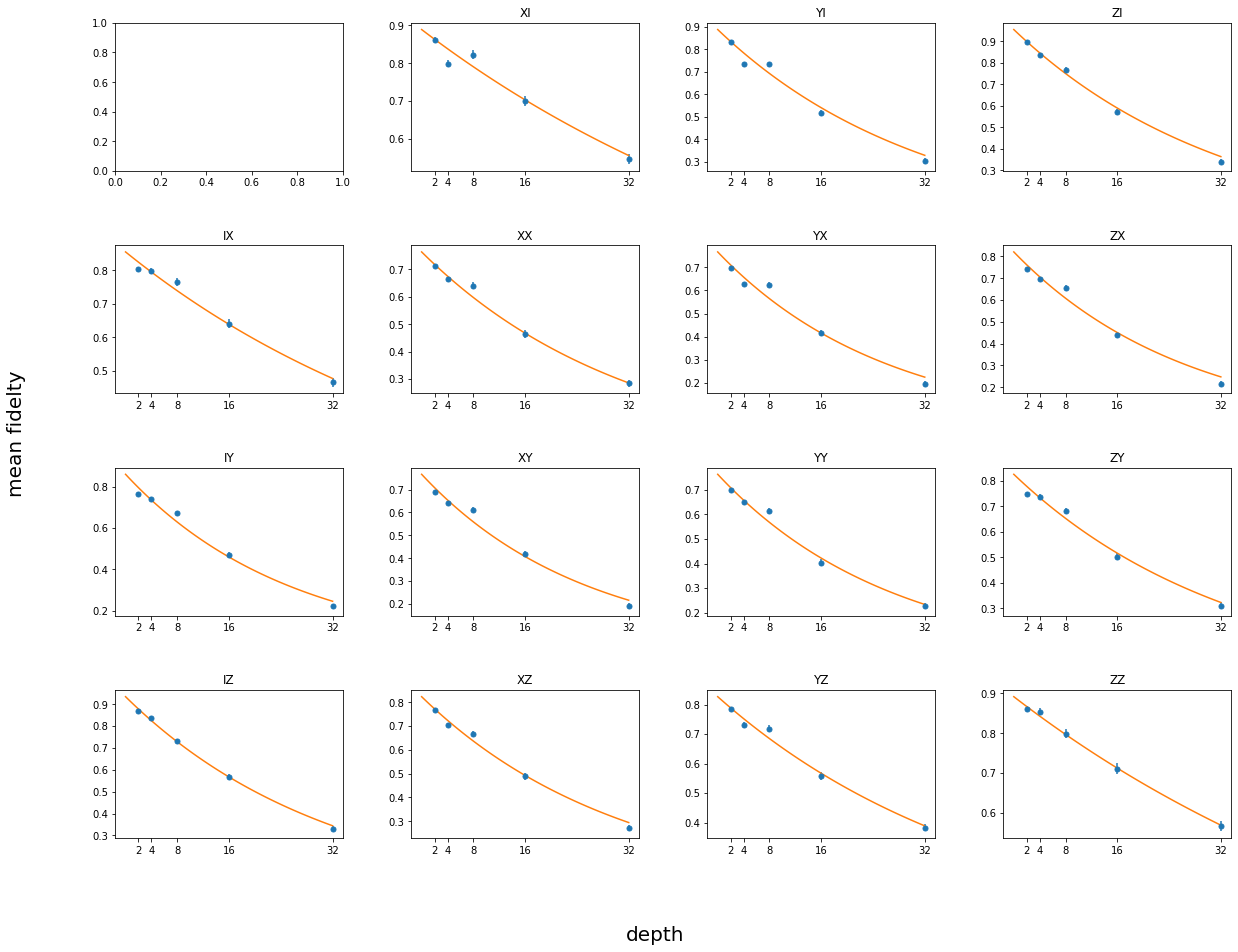

In [17]:
import bootstrap

raw_fidelity_list = eab_result["fidelity_list"]
plot_dic={}
error_dic={}
# sys.exit(0)
depth=[2,4,8,16,32]
fidelity_list = {}
stdev_list = {}
alpha_detail={}
a_detail={}
alpha_error_detail={}
Y_detail={}
Y_err_detail={}
# a248_dic={}
# Y248_dic={}
# Yerr248_dic={}
for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        fidelity_list[pauli_label] = 1.0
        stdev_list[pauli_label] = 0.0
    else:
        alpha_bootstrap,alpha_err_bootstrap, alpha_rtn_frm_fit,a_rtn_frm_fit, alpha_err_rtn_frm_fit,Y_rtn_frm_fit,Yerr_rtn_frm_fit = bootstrap.bootstrap_fit_EAB_plot_rs(depth, raw_fidelity_list[pauli_label],15)
        fidelity_list[pauli_label] = alpha_bootstrap #pauli fidelity from fit
        stdev_list[pauli_label] = alpha_err_bootstrap #error on pauli fidelity from fit
#         a248_dic[pauli_label]=a 
#         Y248_dic[pauli_label]=Y
        Yerr248_dic[pauli_label]=Yerr
        alpha_detail[pauli_label]=alpha_rtn_frm_fit
        alpha_error_detail[pauli_label]=alpha_err_rtn_frm_fit
        Y_detail[pauli_label]=Y_rtn_frm_fit
        Y_err_detail[pauli_label]=Yerr_rtn_frm_fit

        
print("Parameters: n = %d, C = %d, " % (nqubit,C), "L = ", str(depth))
use_density_matrix=False
use_readout_error =False
shots=2000
if use_density_matrix:
    print("Density matrix based simulation")
else:
    print("Measurement based simulation, shots = %d" % shots)

if use_readout_error is True:
    print("Measurement bitflip rate = %f" % eps_readout)
else:
    print("No readout error")

# Average fidelity
print("Total error = ", 1-np.mean(list(fidelity_list.values())))        
for pauli_label in pauli_request_list:
    if(pauli_label == 'I'*nqubit):
        continue
    else:
        print (pauli_label[::-1],round(1-fidelity_list[pauli_label],7),round(stdev_list[pauli_label],7))

print (alpha_detail[pauli_label])


x_c=np.linspace(0,32,num=80)
nqubit=2
fig, axs = plt.subplots(4, 4)
fig.set_figwidth(20)
fig.set_figheight(15)
fig.subplots_adjust(hspace=0.5,wspace=0.3) 
fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
for i in range (4):
    for j in range(4):
        pauli_label=pauli_request_list[4*i+j]
        if (pauli_label == 'I'*nqubit):
#                 fidelity_list[pauli_label] = 1.0
#                 stdev_list[pauli_label] = 0.0
            pass
        else:
            axs[i, j].set_xticks([2,4,8,16,32])   
            axs[i, j].errorbar(depth,Y248_dic[pauli_label], yerr=Yerr248_dic[pauli_label], fmt='o',markersize=5)
            axs[i, j].plot(x_c,rcs_fit_fun(x_c,a248_dic[pauli_label], fidelity_list[pauli_label]))
            axs[i, j].set_title(pauli_label[::-1])
# x_c=np.linspace(0,32,num=80)
# nqubit=2
# fig, axs = plt.subplots(8, 2)
# fig.set_figwidth(10)
# fig.set_figheight(50)
# fig.subplots_adjust(hspace=0.5,wspace=0.3) 
# fig.text(0.5, 0.03, 'depth', ha='center',fontsize=20)
# fig.text(0.05, 0.5, 'mean fidelty', va='center', rotation='vertical',fontsize=20)
# for i in range (8):
#     for j in range(2):
#         pauli_label=pauli_request_list[2*i+j]
#         if (pauli_label == 'I'*nqubit):
# #                 fidelity_list[pauli_label] = 1.0
# #                 stdev_list[pauli_label] = 0.0
#             pass
#         else:
#             axs[i, j].set_xticks([2,4,8,16,32])   
# #             axs[i, j].errorbar(depth,Y248_dic[pauli_label], yerr=Yerr248_dic[pauli_label], fmt='o',markersize=5)
#             print ([tuple(eab_result['fidelity_list'][pauli_label][2])])
# #             axs[i, j].plot([2],[tuple(eab_result['fidelity_list'][pauli_label][2])],"*",markersize=3)
# #             axs[i, j].plot([4],[tuple(eab_result['fidelity_list'][pauli_label][4])],"*",markersize=3)
# #             axs[i, j].plot([8],[tuple(eab_result['fidelity_list'][pauli_label][8])],"*",markersize=3)
# #             axs[i, j].plot([16],[tuple(eab_result['fidelity_list'][pauli_label][16])],"*",markersize=3)
# #             axs[i, j].plot([32],[tuple(eab_result['fidelity_list'][pauli_label][32])],"*",markersize=3)
#             axs[i, j].plot(depth,[tuple(eab_result['fidelity_list'][pauli_label][L]) for L in depth],"*",markersize=3)
#             axs[i, j].errorbar(depth,Y248_dic[pauli_label], yerr=Yerr248_dic[pauli_label], fmt='o',markersize=8)
#             axs[i, j].plot(x_c,rcs_fit_fun(x_c,a248_dic[pauli_label], fidelity_list[pauli_label]))
#             axs[i, j].set_title(pauli_label[::-1])
                
# # for pauli_label in pauli_request_list:
# # fig.savefig("fit.pdf", format="pdf", dpi=500)      

In [16]:
error_list = fidelity_to_error(fidelity_list,nqubit)
print("Label / Pauli error rates")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], round(error_list[pauli_label],7))


Label / Pauli error rates
II 0.9725343
XI 0.0021013
YI 0.0005666
ZI 0.0029704
IX 0.0029625
XX 0.0068867
YX 0.002631
ZX 0.0007211
IY 0.0001398
XY 0.0017735
YY 0.0002316
ZY -6.45e-05
IZ 0.0057653
XZ 0.0003277
YZ 0.0001325
ZZ 0.0003203


In [14]:
error_list = fidelity_to_error(fidelity_list,nqubit)
print("Label / Pauli error rates")
for pauli_label in pauli_request_list:
    print(pauli_label[::-1], error_list[pauli_label])


Label / Pauli error rates
II 0.972432582062216
XI 0.0023278609811560047
YI 0.0007599910835047463
ZI 0.0027445909314312913
IX 0.0032067821557085763
XX 0.006745933172515067
YX 0.0026286832862785076
ZX 0.0004965948441834067
IY 0.00038102439840762004
XY 0.0019097187670314847
YY 0.00021057493717729914
ZY 0.0001512259906869956
IZ 0.005688058219169845
XZ 0.00023386116423526615
YZ -0.00018864441547654376
ZZ 0.00027116242177432914


In [15]:
print (type(raw_fidelity_list[pauli_label][2]))
print (raw_fidelity_list[pauli_label])

<class 'list'>
{2: [0.772, 0.813, 0.797, 0.756, 0.843, 0.83, 0.772, 0.849, 0.852, 0.811, 0.83, 0.784, 0.847, 0.841, 0.885, 0.834, 0.858, 0.852, 0.853, 0.867], 4: [0.844, 0.818, 0.788, 0.77, 0.878, 0.807, 0.845, 0.854, 0.863, 0.827, 0.766, 0.78, 0.829, 0.8, 0.8, 0.861, 0.686, 0.796, 0.876, 0.803], 8: [0.796, 0.803, 0.72, 0.75, 0.762, 0.705, 0.789, 0.734, 0.671, 0.763, 0.803, 0.724, 0.721, 0.812, 0.729, 0.816, 0.747, 0.686, 0.687, 0.801], 16: [0.718, 0.63, 0.709, 0.681, 0.737, 0.696, 0.672, 0.697, 0.664, 0.719, 0.702, 0.608, 0.611, 0.779, 0.7, 0.673, 0.659, 0.493, 0.705, 0.63], 32: [0.544, 0.588, 0.472, 0.519, 0.558, 0.552, 0.569, 0.517, 0.615, 0.538, 0.541, 0.489, 0.607, 0.59, 0.582, 0.465, 0.461, 0.412, 0.535, 0.548]}


spam results

In [16]:
print (eab_load)

NameError: name 'eab_load' is not defined

In [ ]:
print (type(eab_result["fidelity_list"]["IX"][2]))

In [ ]:
print ([tuple(eab_result['fidelity_list'][pauli_label][2])])
y2=[tuple(eab_result['fidelity_list'][pauli_label][2])]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

y = [(1,1,2,4)]
x = [2]
plt.plot(x,[tuple(eab_result['fidelity_list'][pauli_label][2])],"r*")
plt.show()

In [ ]:

b=[]
c=[1,2]
f=c
c=[1]
print (d)
print (b)
print (c)